In [2]:
from ultralytics.models import YOLO
from PIL import Image
import torch
import numpy as np
import cv2
import tqdm
import segmentation_models_pytorch as smp
from torchvision import transforms
from pathlib import Path
import os
from datetime import datetime

device = "cuda:0"
model = smp.UnetPlusPlus(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid",
    encoder_depth=4,
    decoder_channels=[256, 128, 64, 32],
).to(device)
model.load_state_dict(
    torch.load(
        "ckpts/patch_nuclei__620__0.065.pt",
        map_location=device,
    )
)
model.eval()

patch_trans = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

yolo = YOLO("yolo_ckpts/A.pt").to(device)

def get_yolo_boxes(image_path, yolo, conf=0.4, max_det=2000):
    im = Image.open(image_path).convert("RGB")
    w, h = im.size
    r = yolo.predict(im, conf=conf, max_det=max_det, imgsz=w)[0]
    b = r.boxes.xyxy.cpu().numpy().astype(int)
    if b.shape[0] > 0:
        b = np.hstack([np.ones((b.shape[0], 1)), b, np.ones((b.shape[0], 1))])
    return b

now = datetime.now()
month = now.strftime("%B").lower()
day = now.strftime("%d")
base = f"preds_{month}_{day}"
i = 1
while True:
    out_dir = f"{base}_{i}"
    if not Path(out_dir).exists():
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        break
    i += 1

#images = list(Path("/workspace/yolo-nuke/Segmentation/monuseg/images").rglob("*.tif"))
#imgs = os.listdir("/workspace/yolo-nuke/Segmentation/monuseg/images")
images = list(Path("/workspace/sanika/seg_dataset_pannuke/monuseg/images").rglob("*.tif"))
imgs = os.listdir("/workspace/sanika/seg_dataset_pannuke/monuseg/images")
patient_ids = [j.split(".")[0] for j in imgs]

for ip in images:
    if Path(ip).stem not in patient_ids:
        continue
    boxes = get_yolo_boxes(ip, yolo, conf=0.55, max_det=9999)
    im = cv2.imread(str(ip))
    arr = np.array(boxes)
    arr[arr < 0] = 0
    arr = arr.astype(int)
    h, w = im.shape[:2]
    sm = np.zeros((h, w), dtype=np.int32)
    c = 1
    for it in tqdm.tqdm(arr[:, 1:-1], ncols=50):
        x1, y1, x2, y2 = it
        x1, y1, x2, y2 = x1 - 4, y1 - 4, x2 + 4, y2 + 4
        x1, y1 = max(x1, 0), max(y1, 0)
        x2, y2 = min(x2, w - 1), min(y2, h - 1)
        p = cv2.resize(im[y1:y2, x1:x2], (64, 64))
        p = patch_trans(Image.fromarray(p)).to(device)
        p = torch.unsqueeze(p, 0)
        with torch.no_grad():
            pm = model(p).squeeze().cpu().numpy()
        pm = cv2.resize(pm, (x2 - x1, y2 - y1))
        pm = cv2.dilate(pm, (3, 3))
        sm[y1:y2, x1:x2][pm > 0.5] = c
        c += 1
    np.save(f"{out_dir}/{Path(ip).stem}", sm)



WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 1524 nucleuss, 8.7ms
Speed: 9.8ms preprocess, 8.7ms inference, 80.7ms postprocess per image at shape (1, 3, 1024, 1024)



00%|████████| 1524/1524 [00:05<00:00, 272.12it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 585 nucleuss, 9.6ms
Speed: 5.5ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 585/585 [00:02<00:00, 282.69it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 486 nucleuss, 9.5ms
Speed: 5.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)




00%|██████████| 486/486 [00:01<00:00, 286.28it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 726 nucleuss, 8.8ms
Speed: 5.5ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 726/726 [00:02<00:00, 285.37it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 322 nucleuss, 9.1ms


Speed: 5.6ms preprocess, 9.1ms inference, 12.8ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 322/322 [00:01<00:00, 287.14it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 789 nucleuss, 8.7ms
Speed: 5.3ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)



100%|██████████| 789/789 [00:02<00:00, 287.76it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 324 nucleuss, 9.2ms
Speed: 4.8ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)



100%|██████████| 324/324 [00:01<00:00, 287.49it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 449 nucleuss, 8.7ms
Speed: 5.4ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)



100%|██████████| 449/449 [00:01<00:00, 287.47it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 635 nucleuss, 9.0ms
Speed: 5.1ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 635/635 [00:02<00:00, 285.62it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 1167 nucleuss, 9.4ms
Speed: 4.8ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 1024, 1024)



00%|████████| 1167/1167 [00:04<00:00, 285.18it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 330 nucleuss, 9.9ms
Speed: 5.2ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 330/330 [00:01<00:00, 286.88it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 485 nucleuss, 9.2ms
Speed: 5.2ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 485/485 [00:01<00:00, 290.81it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 389 nucleuss, 9.4ms
Speed: 4.8ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 389/389 [00:01<00:00, 287.05it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 724 nucleuss, 11.6ms
Speed: 5.0ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 724/724 [00:02<00:00, 288.01it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 304 nucleuss, 9.9ms
Speed: 5.3ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 304/304 [00:01<00:00, 289.57it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 511 nucleuss, 9.1ms
Speed: 5.0ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 511/511 [00:01<00:00, 289.77it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 419 nucleuss, 9.5ms
Speed: 5.1ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 419/419 [00:01<00:00, 288.00it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 1143 nucleuss, 9.0ms
Speed: 4.8ms preprocess, 9.0ms inference, 3.1ms postprocess per image at shape (1, 3, 1024, 1024)


100%|████████| 1143/1143 [00:03<00:00, 286.55it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 382 nucleuss, 9.7ms
Speed: 5.4ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)




00%|██████████| 382/382 [00:01<00:00, 226.85it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 314 nucleuss, 9.0ms
Speed: 5.2ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 314/314 [00:01<00:00, 289.47it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 210 nucleuss, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 210/210 [00:00<00:00, 289.95it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 344 nucleuss, 9.0ms
Speed: 5.0ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)



100%|██████████| 344/344 [00:01<00:00, 197.83it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 1125 nucleuss, 16.8ms
Speed: 6.2ms preprocess, 16.8ms inference, 12.3ms postprocess per image at shape (1, 3, 1024, 1024)


100%|████████| 1125/1125 [00:06<00:00, 170.48it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 746 nucleuss, 16.6ms
Speed: 5.6ms preprocess, 16.6ms inference, 12.4ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 746/746 [00:03<00:00, 199.20it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 755 nucleuss, 10.9ms
Speed: 5.6ms preprocess, 10.9ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 1024)




00%|██████████| 755/755 [00:04<00:00, 179.12it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 428 nucleuss, 16.7ms
Speed: 5.7ms preprocess, 16.7ms inference, 12.6ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 428/428 [00:02<00:00, 179.94it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 376 nucleuss, 16.9ms
Speed: 6.4ms preprocess, 16.9ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 376/376 [00:02<00:00, 177.34it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 351 nucleuss, 14.8ms
Speed: 5.3ms preprocess, 14.8ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 351/351 [00:01<00:00, 178.26it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 1351 nucleuss, 16.8ms
Speed: 6.1ms preprocess, 16.8ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)



00%|████████| 1351/1351 [00:07<00:00, 169.58it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 354 nucleuss, 16.8ms
Speed: 20.1ms preprocess, 16.8ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 354/354 [00:02<00:00, 176.13it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 246 nucleuss, 16.7ms
Speed: 5.7ms preprocess, 16.7ms inference, 12.4ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 246/246 [00:01<00:00, 179.22it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 1112 nucleuss, 16.7ms
Speed: 6.5ms preprocess, 16.7ms inference, 12.6ms postprocess per image at shape (1, 3, 1024, 1024)




00%|████████| 1112/1112 [00:06<00:00, 180.05it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 438 nucleuss, 16.6ms
Speed: 6.2ms preprocess, 16.6ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 438/438 [00:02<00:00, 178.32it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 468 nucleuss, 11.5ms
Speed: 5.7ms preprocess, 11.5ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 468/468 [00:02<00:00, 174.95it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 460 nucleuss, 16.7ms
Speed: 6.4ms preprocess, 16.7ms inference, 12.3ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 460/460 [00:02<00:00, 171.65it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 305 nucleuss, 16.6ms
Speed: 4.9ms preprocess, 16.6ms inference, 12.3ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 305/305 [00:01<00:00, 180.01it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 472 nucleuss, 16.8ms
Speed: 7.0ms preprocess, 16.8ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 472/472 [00:02<00:00, 180.46it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 394 nucleuss, 16.9ms
Speed: 6.3ms preprocess, 16.9ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 394/394 [00:02<00:00, 178.99it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 1253 nucleuss, 17.0ms
Speed: 6.6ms preprocess, 17.0ms inference, 12.6ms postprocess per image at shape (1, 3, 1024, 1024)



00%|████████| 1253/1253 [00:06<00:00, 179.37it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 321 nucleuss, 16.6ms
Speed: 5.0ms preprocess, 16.6ms inference, 12.3ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 321/321 [00:01<00:00, 171.33it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 356 nucleuss, 16.6ms
Speed: 5.0ms preprocess, 16.6ms inference, 12.3ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 356/356 [00:02<00:00, 171.34it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 560 nucleuss, 16.8ms
Speed: 5.0ms preprocess, 16.8ms inference, 12.4ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 560/560 [00:03<00:00, 178.29it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 431 nucleuss, 16.8ms
Speed: 6.0ms preprocess, 16.8ms inference, 12.4ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 431/431 [00:02<00:00, 179.46it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 1314 nucleuss, 17.0ms
Speed: 6.3ms preprocess, 17.0ms inference, 12.6ms postprocess per image at shape (1, 3, 1024, 1024)


100%|████████| 1314/1314 [00:07<00:00, 178.66it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 1303 nucleuss, 11.3ms
Speed: 6.1ms preprocess, 11.3ms inference, 4.2ms postprocess per image at shape (1, 3, 1024, 1024)


100%|████████| 1303/1303 [00:07<00:00, 168.95it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 457 nucleuss, 16.6ms
Speed: 6.4ms preprocess, 16.6ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 457/457 [00:02<00:00, 180.62it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 352 nucleuss, 16.9ms
Speed: 6.5ms preprocess, 16.9ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 352/352 [00:01<00:00, 181.04it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


0: 1024x1024 491 nucleuss, 16.8ms
Speed: 5.7ms preprocess, 16.8ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 491/491 [00:02<00:00, 178.43it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 316 nucleuss, 16.7ms
Speed: 6.8ms preprocess, 16.7ms inference, 12.4ms postprocess per image at shape (1, 3, 1024, 1024)



00%|██████████| 316/316 [00:01<00:00, 177.63it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 367 nucleuss, 16.9ms
Speed: 6.9ms preprocess, 16.9ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 367/367 [00:02<00:00, 180.74it/s]


WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 1024x1024 363 nucleuss, 8.8ms
Speed: 4.9ms preprocess, 8.8ms inference, 12.5ms postprocess per image at shape (1, 3, 1024, 1024)




00%|██████████| 363/363 [00:02<00:00, 174.31it/s]

In [3]:
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import linear_sum_assignment

import os

files = sorted(os.listdir(out_dir))
patient_ids = [f[:-4] for f in files]
print(patient_ids)

# --------------------------Optimised for Speed
def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from
    over-penalisation similar to DICE2.

    Fast computation requires instance IDs are in contiguous ordering i.e [1, 2, 3, 4]
    not [2, 3, 6, 10]. Please call `remap_label` beforehand and `by_size` flag has no
    effect on the result.
    """
    pred = remap_label(pred)
    true = remap_label(true)
    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    # Prepare instance masks
    true_masks = [None]
    for t in true_id_list[1:]:
        t_mask = (true == t).astype(np.uint8)
        true_masks.append(t_mask)

    pred_masks = [None]
    for p in pred_id_list[1:]:
        p_mask = (pred == p).astype(np.uint8)
        pred_masks.append(p_mask)

    pairwise_inter = np.zeros([len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64)
    pairwise_union = np.zeros([len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64)

    # Fill pairwise intersections/unions
    for t_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[t_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for p_id in pred_true_overlap_id:
            if p_id == 0:
                continue
            p_mask = pred_masks[p_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[t_id - 1, p_id - 1] = inter
            pairwise_union[t_id - 1, p_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # For each GT, pick the pred that gives highest IoU
    paired_pred = np.argmax(pairwise_iou, axis=1)
    max_iou = np.max(pairwise_iou, axis=1)
    # Filter out GT with no intersection
    paired_true = np.nonzero(max_iou > 0.0)[0]  # indices
    paired_pred = paired_pred[paired_true]

    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    # Convert from index to actual IDs
    paired_true = list(paired_true + 1)
    paired_pred = list(paired_pred + 1)

    # Add unpaired GT + Pred to union
    unpaired_true = [x for x in true_id_list[1:] if x not in paired_true]
    unpaired_pred = [x for x in pred_id_list[1:] if x not in paired_pred]
    for t_id in unpaired_true:
        overall_union += true_masks[t_id].sum()
    for p_id in unpaired_pred:
        overall_union += pred_masks[p_id].sum()

    aji_score = overall_inter / overall_union if overall_union else 0.0
    return aji_score


from scipy.optimize import linear_sum_assignment
import numpy as np

def get_fast_aji_plus(true, pred):
    """
    AJI+ (Aggregated Jaccard Index Plus) with maximal unique pairing.
    1. Remap labels to ensure contiguous IDs: 0,1,2,...
    2. Build dictionaries of {inst_id: mask}.
    3. Compute pairwise intersection & union for GT and Pred.
    4. Use Hungarian (linear_sum_assignment) to find the best 1-to-1 matching.
    5. Sum intersection over matched pairs, and union over matched + unpaired IDs.
    6. Return the AJI+ = total_inter / total_union.

    Note: 'true' and 'pred' must be 2D integer arrays with instance IDs.
    ID 0 is background (ignored).
    """
    # ---------------------
    # 1) Remap label => 0..N contiguous
    # ---------------------
    true = remap_label(true)
    pred = remap_label(pred)
    # Make copies to avoid side effects
    true = np.copy(true)
    pred = np.copy(pred)

    # Collect unique IDs
    true_id_list = sorted(list(np.unique(true)))
    pred_id_list = sorted(list(np.unique(pred)))

    # Remove background from ID lists
    if 0 in true_id_list:
        true_id_list.remove(0)
    if 0 in pred_id_list:
        pred_id_list.remove(0)

    # Edge case: if no nuclei in GT or Pred, AJI+ is 0
    if len(true_id_list) == 0 or len(pred_id_list) == 0:
        return 0.0

    # ---------------------
    # 2) Build dictionaries: {id: mask}
    # ---------------------
    # Each dict key = instance ID, value = binary mask for that instance
    true_masks = {}
    for t_id in true_id_list:
        mask = (true == t_id).astype(np.uint8)
        true_masks[t_id] = mask

    pred_masks = {}
    for p_id in pred_id_list:
        mask = (pred == p_id).astype(np.uint8)
        pred_masks[p_id] = mask

    # ---------------------
    # 3) Compute pairwise intersection & union
    # ---------------------
    # We'll store them in a 2D array, rows=GT IDs, cols=Pred IDs
    n_true = len(true_id_list)
    n_pred = len(pred_id_list)

    pairwise_inter = np.zeros((n_true, n_pred), dtype=np.float64)
    pairwise_union = np.zeros((n_true, n_pred), dtype=np.float64)

    # Create quick ID -> row/col mapping
    #   E.g. if true_id_list = [1,4,9], then row_idx_of[1] = 0, row_idx_of[4] = 1, row_idx_of[9]=2
    row_idx_of = {tid: r for r, tid in enumerate(true_id_list)}
    col_idx_of = {pid: c for c, pid in enumerate(pred_id_list)}

    # For each ground-truth instance t_id
    for t_id in true_id_list:
        t_mask = true_masks[t_id]
        # Find which predicted IDs actually overlap t_mask
        overlapped_pred_ids = np.unique(pred[t_mask > 0])
        # We only care about predicted IDs > 0
        overlapped_pred_ids = overlapped_pred_ids[overlapped_pred_ids > 0]

        for p_id in overlapped_pred_ids:
            p_mask = pred_masks[p_id]
            union_ = (t_mask + p_mask).sum()
            inter_ = (t_mask * p_mask).sum()
            r = row_idx_of[t_id]
            c = col_idx_of[p_id]
            pairwise_inter[r, c] = inter_
            pairwise_union[r, c] = union_ - inter_

    # ---------------------
    # 4) Hungarian matching for best 1-to-1 pairing
    # ---------------------
    pairwise_iou = pairwise_inter / (pairwise_union + 1e-6)
    row_idx, col_idx = linear_sum_assignment(-pairwise_iou)  # maximize IoU
    matched_iou = pairwise_iou[row_idx, col_idx]

    # Filter out zero-overlap matches
    valid_matches = matched_iou > 0
    row_idx = row_idx[valid_matches]
    col_idx = col_idx[valid_matches]

    # Summation of matched intersection and union
    matched_inter = pairwise_inter[row_idx, col_idx]
    matched_union = pairwise_union[row_idx, col_idx]
    overall_inter = matched_inter.sum()
    overall_union = matched_union.sum()

    # ---------------------
    # 5) Add union from unpaired GT and Pred
    # ---------------------
    # Convert row/col indices to actual IDs
    paired_true_ids = [true_id_list[r] for r in row_idx]
    paired_pred_ids = [pred_id_list[c] for c in col_idx]

    unpaired_true = [tid for tid in true_id_list if tid not in paired_true_ids]
    unpaired_pred = [pid for pid in pred_id_list if pid not in paired_pred_ids]

    for t_id in unpaired_true:
        overall_union += true_masks[t_id].sum()
    for p_id in unpaired_pred:
        overall_union += pred_masks[p_id].sum()

    # ---------------------
    # 6) Compute AJI+ score
    # ---------------------
    aji_plus = overall_inter / overall_union if overall_union > 0 else 0.0
    return aji_plus

def remap_label(mask, by_size=False):
    """
    Rename all instance IDs in 'mask' so that they are contiguous [0..N].
    If 'by_size' is True, larger instances get smaller IDs (sorted by descending size).
    """
    mask = np.copy(mask)
    inst_ids = sorted(np.unique(mask))
    if 0 in inst_ids:
        inst_ids.remove(0)
    if len(inst_ids) == 0:
        return mask

    if by_size:
        sizes = [(id_, (mask == id_).sum()) for id_ in inst_ids]
        sizes.sort(key=lambda x: x[1], reverse=True)
        inst_ids = [x[0] for x in sizes]

    new_mask = np.zeros_like(mask, dtype=np.int32)
    for new_id, old_id in enumerate(inst_ids, start=1):
        new_mask[mask == old_id] = new_id
    return new_mask




def get_fast_pq(true, pred, match_iou=0.5):
    """
    `match_iou` is the IoU threshold level to determine the pairing between
    GT instances and pred instances. 1:1 mapping. If match_iou < 0.5, we do
    Hungarian matching to maximize total IoU. If >=0.5, the assumption is that
    any IoU>0.5 pair is unique already.
    """
    assert match_iou >= 0.0, "Cant' be negative"
    pred = remap_label(pred)
    true = remap_label(true)
    true = np.copy(true)
    pred = np.copy(pred)

    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [None]
    for t_id in true_id_list[1:]:
        t_mask = (true == t_id).astype(np.uint8)
        true_masks.append(t_mask)

    pred_masks = [None]
    for p_id in pred_id_list[1:]:
        p_mask = (pred == p_id).astype(np.uint8)
        pred_masks.append(p_mask)

    pairwise_iou = np.zeros([len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64)

    # Calculate IoU for each pair
    for t_id in true_id_list[1:]:
        t_mask = true_masks[t_id]
        pred_true_overlap = list(np.unique(pred[t_mask > 0]))
        for p_id in pred_true_overlap:
            if p_id == 0:
                continue
            p_mask = pred_masks[p_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter + 1e-6)
            pairwise_iou[t_id - 1, p_id - 1] = iou

    if match_iou >= 0.5:
        # direct matching
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        r_idx, c_idx = np.nonzero(pairwise_iou)
        matched_iou = pairwise_iou[r_idx, c_idx]
        # shift instance IDs
        paired_true = list(r_idx + 1)
        paired_pred = list(c_idx + 1)
    else:
        # Hungarian
        r_idx, c_idx = linear_sum_assignment(-pairwise_iou)
        matched_iou = pairwise_iou[r_idx, c_idx]
        valid = matched_iou > match_iou
        r_idx = r_idx[valid]
        c_idx = c_idx[valid]
        matched_iou = matched_iou[valid]
        paired_true = list(r_idx + 1)
        paired_pred = list(c_idx + 1)

    tp = len(paired_true)
    unpaired_true = [t for t in true_id_list[1:] if t not in paired_true]
    unpaired_pred = [p for p in pred_id_list[1:] if p not in paired_pred]
    fp = len(unpaired_pred)
    fn = len(unpaired_true)

    # DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn + 1e-6)
    # SQ
    sq = matched_iou.sum() / (tp + 1e-6)
    return [dq, sq, dq * sq], [paired_true, paired_pred, unpaired_true, unpaired_pred]

def get_fast_pq2(true, pred, match_iou=0.3):
    """
    Compute Panoptic Quality (PQ) in a 'fast' way by enforcing one-to-one
    matches using the Hungarian (Munkres) method for all IoU thresholds.
    This avoids the incorrect shortcut that assumes IoU >= 0.5 implies uniqueness.

    Args:
        true (np.ndarray): 2D integer array with ground-truth instance labels.
        pred (np.ndarray): 2D integer array with predicted instance labels.
        match_iou (float): IoU threshold for deciding matches. Defaults to 0.5.

    Returns:
        metrics (list): [DQ, SQ, PQ]
        pairing_info (list): [paired_true_ids, paired_pred_ids, unpaired_true_ids, unpaired_pred_ids]
    """

    # Remap labels so that instance IDs are contiguous: 0, 1, 2, ...
    true = remap_label(true)
    pred = remap_label(pred)
    true = np.copy(true)
    pred = np.copy(pred)

    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    # Build masks for each instance
    # Index 0 is None / placeholder for background
    true_masks = [None]
    for t_id in true_id_list[1:]:
        true_masks.append((true == t_id).astype(np.uint8))

    pred_masks = [None]
    for p_id in pred_id_list[1:]:
        pred_masks.append((pred == p_id).astype(np.uint8))

    # pairwise_iou will be (num_true, num_pred)
    pairwise_iou = np.zeros((len(true_id_list) - 1, len(pred_id_list) - 1), dtype=np.float64)

    # Compute IoU for every pair (true_id, pred_id)
    for t_idx, t_id in enumerate(true_id_list[1:], start=0):
        t_mask = true_masks[t_idx + 1]  # t_idx=0 => t_id=1
        # Find which predictions actually overlap t_mask
        pred_ids_in_true = np.unique(pred[t_mask > 0])
        for p_id in pred_ids_in_true:
            if p_id == 0:
                continue
            p_idx = p_id - 1
            p_mask = pred_masks[p_idx + 1]
            union = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (union - inter + 1.0e-6)  # = inter / (|A| + |B| - inter)
            pairwise_iou[t_idx, p_idx] = iou

    # ---------------------------------------------------------
    # ALWAYS do a bipartite matching using Hungarian method
    # ---------------------------------------------------------
    # Negative because linear_sum_assignment() finds minimal cost, we want maximal IoU
    row_ids, col_ids = linear_sum_assignment(-pairwise_iou)
    matched_ious = pairwise_iou[row_ids, col_ids]

    # Filter out matches with IoU below threshold
    valid = matched_ious > match_iou
    row_ids = row_ids[valid]
    col_ids = col_ids[valid]
    matched_ious = matched_ious[valid]

    # Convert row/col indices to actual instance IDs
    # (Because row=0 => true_id=1, col=0 => pred_id=1)
    paired_true_ids = row_ids + 1
    paired_pred_ids = col_ids + 1

    # ---------------------------------------------------------
    # Count TPs, FPs, FNs
    # ---------------------------------------------------------
    tp = len(paired_true_ids)
    unpaired_true_ids = [t for t in true_id_list[1:] if t not in paired_true_ids]
    unpaired_pred_ids = [p for p in pred_id_list[1:] if p not in paired_pred_ids]
    fp = len(unpaired_pred_ids)
    fn = len(unpaired_true_ids)

    # ---------------------------------------------------------
    # Calculate DQ, SQ, PQ
    # ---------------------------------------------------------
    # Detection Quality (DQ)
    #   = TP / (TP + 0.5 * FP + 0.5 * FN)
    dq = tp / (tp + 0.5 * fp + 0.5 * fn + 1.0e-6)

    # Segmentation Quality (SQ)
    #   = average IoU of matched pairs
    sq = matched_ious.mean() if tp > 0 else 0.0

    pq = dq * sq

    return [dq, sq, pq], [paired_true_ids, paired_pred_ids, unpaired_true_ids, unpaired_pred_ids]

def get_fast_dice_2(true, pred):
    """Ensemble dice with instance-level summation."""
    true = np.copy(true)
    pred = np.copy(pred)
    
    true_id = list(np.unique(true))
    pred_id = list(np.unique(pred))

    # Build separate arrays for each true instance
    true_masks = [np.zeros_like(true, dtype=np.uint8)]
    for t in true_id[1:]:
        true_masks.append((true == t).astype(np.uint8))

    # Build separate arrays for each predicted instance
    pred_masks = [np.zeros_like(pred, dtype=np.uint8)]
    for p in pred_id[1:]:
        pred_masks.append((pred == p).astype(np.uint8))

    overall_total = 0
    overall_inter = 0

    # For each true instance
    for t_idx in range(1, len(true_id)):
        t_mask = true_masks[t_idx]
        pred_true_overlap = list(np.unique(pred[t_mask > 0]))
        
        if 0 in pred_true_overlap:
            pred_true_overlap.remove(0)
        
        for p_idx in pred_true_overlap:
            p_mask = pred_masks[p_idx]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            overall_total += total
            overall_inter += inter

    return 2 * overall_inter / (overall_total + 1e-6)


def get_dice_1(true, pred):
    """Traditional dice over entire mask (binary)."""
    true = np.copy(true)
    pred = np.copy(pred)
    true[true > 0] = 1
    pred[pred > 0] = 1
    inter = (true * pred).sum()
    union = (true + pred).sum()
    return 2.0 * inter / (union + 1e-6)


def get_dice_2(true, pred):
    """Ensemble Dice as used in certain challenges (with instance-level summation)."""
    true = np.copy(true)
    pred = np.copy(pred)
    true_id = list(np.unique(true))
    pred_id = list(np.unique(pred))

    # Safely remove background ID 0 if present
    if 0 in true_id:
        true_id.remove(0)
    if 0 in pred_id:
        pred_id.remove(0)

    total_markup = 0
    total_intersect = 0
    for t in true_id:
        t_mask = (true == t).astype(np.uint8)
        for p in pred_id:
            p_mask = (pred == p).astype(np.uint8)
            intersect = (p_mask * t_mask).sum()
            if intersect > 0:
                total_intersect += intersect
                total_markup += t_mask.sum() + p_mask.sum()
    return 2 * total_intersect / (total_markup + 1e-6)


def remap_label(pred, by_size=False):
    """
    Rename all instance IDs so they are contiguous [0,1,2,3,...].
    The ordering is preserved unless by_size=True, then bigger nuclei get smaller IDs.

    If 0 isn't in the unique labels, we skip removing it.
    """
    pred_id = list(np.unique(pred))
    if 0 in pred_id:
        pred_id.remove(0)

    if len(pred_id) == 0:
        return pred  # no label

    if by_size:
        # Sort by nucleus size (descending)
        pred_size = [(inst_id, (pred == inst_id).sum()) for inst_id in pred_id]
        pred_size.sort(key=lambda x: x[1], reverse=True)
        pred_id = [x[0] for x in pred_size]

    new_pred = np.zeros_like(pred, dtype=np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred


def pair_coordinates(setA, setB, radius):
    """
    Use the Hungarian algorithm to find an optimal pairing of points in setB vs setA
    using Euclidean distance as cost. Only keep pairs with distance <= radius.
    Returns (pairing, unpairedA, unpairedB).
    """
    pair_distance = scipy.spatial.distance.cdist(setA, setB, metric="euclidean")
    indicesA, paired_indicesB = linear_sum_assignment(pair_distance)
    pair_cost = pair_distance[indicesA, paired_indicesB]

    valid = pair_cost <= radius
    pairedA = indicesA[valid]
    pairedB = paired_indicesB[valid]

    pairing = np.column_stack([pairedA, pairedB])
    unpairedA = np.delete(np.arange(setA.shape[0]), pairedA)
    unpairedB = np.delete(np.arange(setB.shape[0]), pairedB)
    return pairing, unpairedA, unpairedB


def combine_masks(mask_stack):
    """
    Combine a stack of binary masks (shape: [N, H, W])
    into a single label map (shape: [H, W]) where each nucleus gets a unique label.
    """
    label_map = np.zeros(mask_stack.shape[1:], dtype=np.int32)
    for i in range(mask_stack.shape[0]):
        label_map[mask_stack[i] > 0] = i + 1
    return label_map


['TCGA-18-5592-01Z-00-DX1', 'TCGA-21-5784-01Z-00-DX1', 'TCGA-21-5786-01Z-00-DX1', 'TCGA-2Z-A9J9-01A-01-TS1', 'TCGA-38-6178-01Z-00-DX1', 'TCGA-44-2665-01B-06-BS6', 'TCGA-49-4488-01Z-00-DX1', 'TCGA-50-5931-01Z-00-DX1', 'TCGA-69-7764-01A-01-TS1', 'TCGA-A6-6782-01A-01-BS1', 'TCGA-A7-A13E-01Z-00-DX1', 'TCGA-A7-A13F-01Z-00-DX1', 'TCGA-AC-A2FO-01A-01-TS1', 'TCGA-AO-A0J2-01A-01-BSA', 'TCGA-AR-A1AK-01Z-00-DX1', 'TCGA-AR-A1AS-01Z-00-DX1', 'TCGA-AY-A8YK-01A-01-TS1', 'TCGA-B0-5698-01Z-00-DX1', 'TCGA-B0-5710-01Z-00-DX1', 'TCGA-B0-5711-01Z-00-DX1', 'TCGA-BC-A217-01Z-00-DX1', 'TCGA-CH-5767-01Z-00-DX1', 'TCGA-CU-A0YN-01A-02-BSB', 'TCGA-DK-A2I6-01A-01-TS1', 'TCGA-E2-A14V-01Z-00-DX1', 'TCGA-E2-A1B5-01Z-00-DX1', 'TCGA-EJ-A46H-01A-03-TSC', 'TCGA-F9-A8NY-01Z-00-DX1', 'TCGA-FG-A4MU-01B-01-TS1', 'TCGA-FG-A87N-01Z-00-DX1', 'TCGA-G2-A2EK-01A-02-TSB', 'TCGA-G9-6336-01Z-00-DX1', 'TCGA-G9-6348-01Z-00-DX1', 'TCGA-G9-6356-01Z-00-DX1', 'TCGA-G9-6362-01Z-00-DX1', 'TCGA-G9-6363-01Z-00-DX1', 'TCGA-GL-6846-01A-01-BS1', 

In [4]:
import glob
import os
from pathlib import Path
import numpy as np
import cv2
from multiprocessing import Pool, cpu_count

# Suppose 'patient_ids' is already defined
# Suppose 'get_fast_pq' and 'get_fast_aji_plus' are defined or imported

#masks = glob.glob('/workspace/yolo-nuke/Segmentation/monuseg/annotations/*.npy')
masks = glob.glob('/workspace/yolo-nuke/Segmentation/monuseg/annotations/*.npy')

def process_one_mask(true_path):
    """
    Reads the annotation mask (true_path) and its corresponding pred_path,
    computes metrics, and returns [stem, dq, sq, pq, aji].
    Returns None if something fails.
    """
    try:
        stem = Path(true_path).stem
        # Skip if not in patient_ids
        if stem not in patient_ids:
            return None

        # Load predicted mask
        # pred_path = f'/workspace/yolo-nuke/Segmentation/exp7/{stem}.npy'
        pred_path = f'{out_dir}/{stem}.npy'
        if not os.path.isfile(pred_path):
            print(f"No predicted mask found for: {stem}")
            return None

        pred_mask = np.load(pred_path)
        true_mask = np.load(true_path)

        # Example computations
        intersection = np.logical_and(pred_mask > 0, true_mask > 0)
        union = np.logical_or(pred_mask > 0, true_mask > 0)

        iou = intersection.sum() / union.sum() if union.sum() > 0 else 0.0
        dice = (2 * intersection.sum()) / ((pred_mask > 0).sum() + (true_mask > 0).sum() + 1e-6)

        # PQ, DQ, SQ
        [dq, sq, pq], _ = get_fast_pq(true_mask, pred_mask, match_iou=0.4)
        # print(pq)
        aji = get_fast_aji_plus(true_mask, pred_mask)
        # print("AJI Pass")
        print(f'{stem} -- DQ={dq:.4f} -- SQ={sq:.4f} -- PQ={pq:.4f} -- AJI={aji:.4f} PredSize={pred_mask.shape} GTSize={true_mask.shape}\n')

        return [stem, dq, sq, pq, aji]

    except Exception as e:
        print(f"Error with {true_path}: {e}")
        return None

# Decide how many processes (or leave None for default, i.e., all CPU cores)
n_processes = 51#cpu_count() - 8  # or e.g. 8
print(f"Using {n_processes} processes.")

with Pool(processes=n_processes) as pool:
    results = pool.map(process_one_mask, masks)

# Filter out None
data = [r for r in results if r is not None]
print("\n=== Finished! ===")
print("Collected results (subset shown):")
for row in data[:5]:
    print(row)
# do something with `data`, e.g. write to CSV



Using 51 processes.
TCGA-B0-5710-01Z-00-DX1 -- DQ=0.8941 -- SQ=0.7136 -- PQ=0.6380 -- AJI=0.6355 PredSize=(1000, 1000) GTSize=(1000, 1000)

TCGA-G9-6348-01Z-00-DX1 -- DQ=0.9490 -- SQ=0.8320 -- PQ=0.7896 -- AJI=0.7930 PredSize=(1000, 1000) GTSize=(1000, 1000)

TCGA-HC-7209-01A-01-TS1 -- DQ=0.8968 -- SQ=0.7368 -- PQ=0.6607 -- AJI=0.6683 PredSize=(1000, 1000) GTSize=(1000, 1000)

TCGA-G2-A2EK-01A-02-TSB -- DQ=0.7079 -- SQ=0.7561 -- PQ=0.5353 -- AJI=0.5892 PredSize=(1000, 1000) GTSize=(1000, 1000)

TCGA-21-5784-01Z-00-DX1 -- DQ=0.9098 -- SQ=0.7810 -- PQ=0.7106 -- AJI=0.7425 PredSize=(1000, 1000) GTSize=(1000, 1000)

TCGA-NH-A8F7-01A-01-TS1 -- DQ=0.9449 -- SQ=0.7523 -- PQ=0.7109 -- AJI=0.7309 PredSize=(1000, 1000) GTSize=(1000, 1000)

TCGA-G9-6356-01Z-00-DX1 -- DQ=0.9667 -- SQ=0.8366 -- PQ=0.8088 -- AJI=0.8069 PredSize=(1000, 1000) GTSize=(1000, 1000)

TCGA-21-5786-01Z-00-DX1 -- DQ=0.9700 -- SQ=0.7709 -- PQ=0.7478 -- AJI=0.7570 PredSize=(1000, 1000) GTSize=(1000, 1000)

TCGA-A7-A13F-01Z-00-

In [5]:
import pandas as pd

df = pd.DataFrame(data, columns=["name", "dq", "sq", "pq", "ajiplus"])
df.to_csv(f"{out_dir}/metrics_{out_dir}.csv", index=False)

In [6]:
df.describe().T['mean']

dq         0.916449
sq         0.763103
pq         0.700920
ajiplus    0.708213
Name: mean, dtype: float64

First five rows:


,name,dq,sq,pq,ajiplus
0,TCGA-HC-7209-01A-01-TS1,0.896764,0.736777,0.660715,0.668347
1,TCGA-IZ-8196-01A-01-BS1,0.910555,0.741590,0.675258,0.674768
2,TCGA-B0-5710-01Z-00-DX1,0.894118,0.713599,0.638042,0.635458
3,TCGA-G2-A2EK-01A-02-TSB,0.707883,0.756148,0.535264,0.589203
4,TCGA-50-5931-01Z-00-DX1,0.951389,0.796219,0.757514,0.773981



Summary Statistics:


,dq,sq,pq,ajiplus
count,51.000000,51.000000,51.000000,51.000000
mean,0.916449,0.763103,0.700920,0.708213
std,0.057270,0.043891,0.074698,0.079892
min,0.707883,0.623742,0.516709,0.503595
25%,0.895441,0.738847,0.660889,0.653537
50%,0.933839,0.760231,0.712110,0.729536
75%,0.956875,0.797502,0.757748,0.770648
max,0.979375,0.836607,0.808782,0.830717


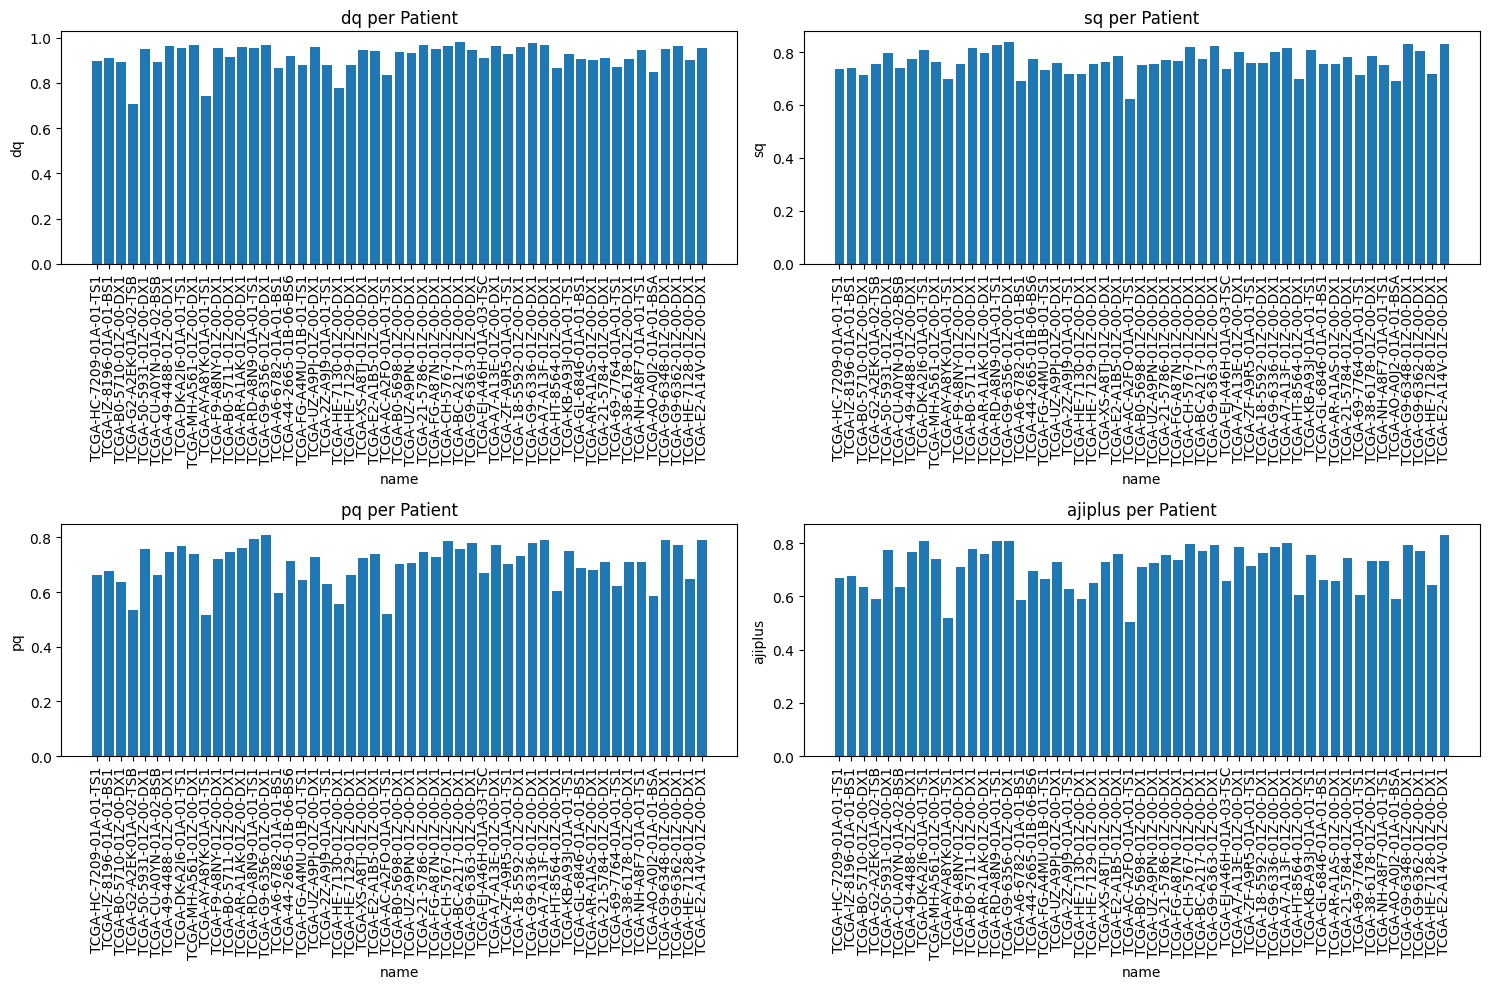

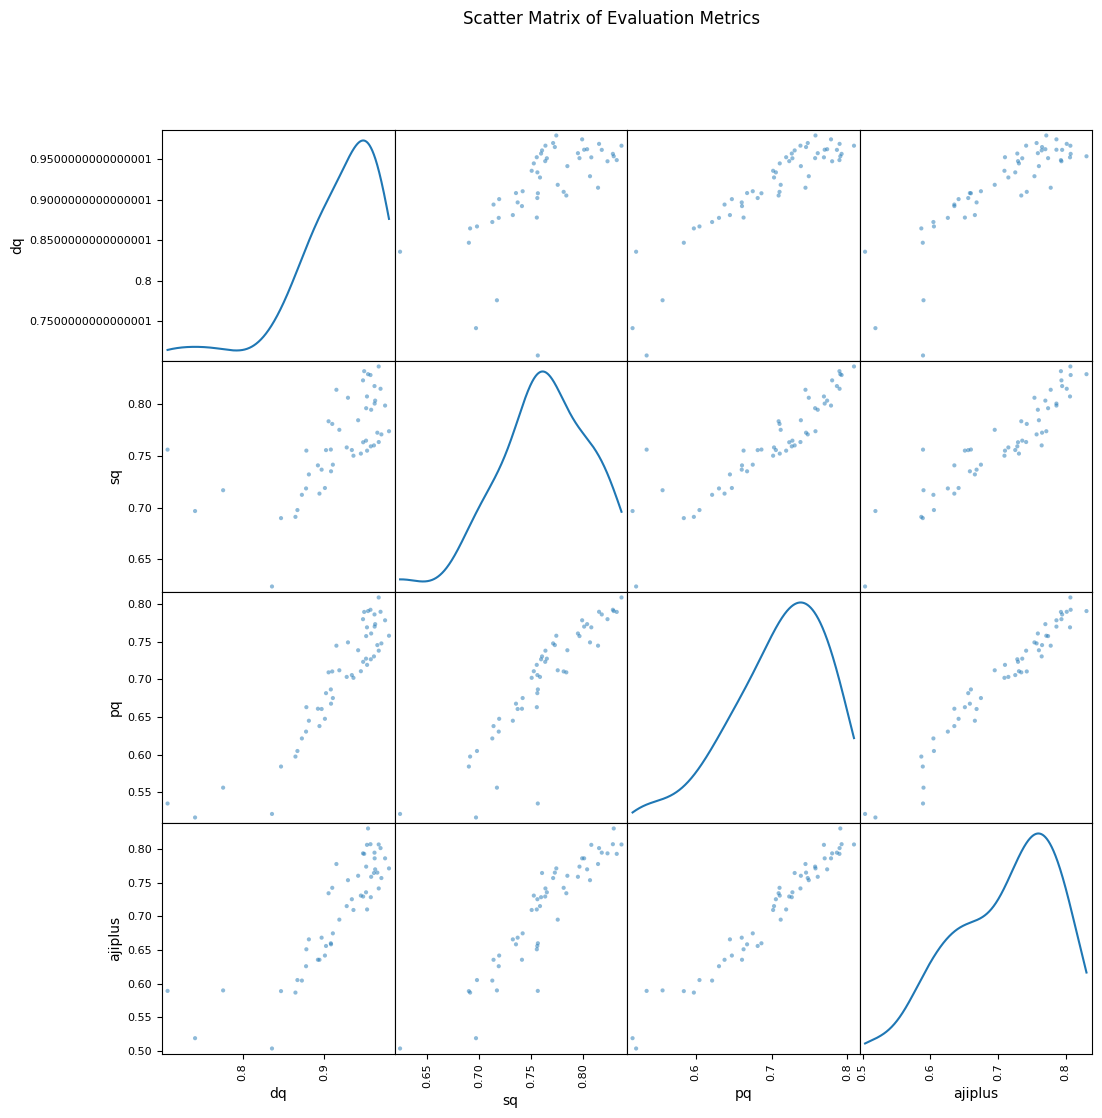

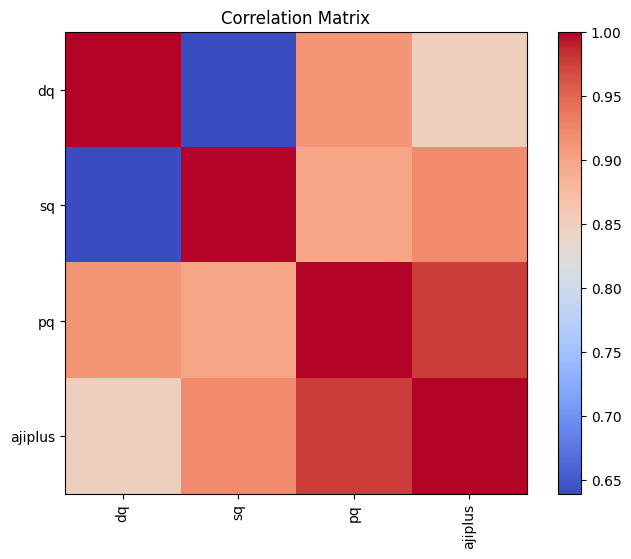

In [7]:
print("First five rows:")
display(df.head())

print("\nSummary Statistics:")
display(df.describe())

# Bar Charts for Each Metric per Image (Patient)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()  # flatten

metrics = ['dq', 'sq', 'pq', 'ajiplus']
for idx, metric in enumerate(metrics):
    axes[idx].bar(df['name'], df[metric])
    axes[idx].set_title(f'{metric} per Patient')
    axes[idx].set_xlabel('name')
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


# Scatter Matrix to visualize relationships between metrics

pd.plotting.scatter_matrix(df[metrics], figsize=(12, 12), diagonal='kde')
plt.suptitle("Scatter Matrix of Evaluation Metrics")
plt.show()


# Correlation Heatmap of the Metrics

corr = df[metrics].corr()
plt.figure(figsize=(8, 6))
im = plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar(im)
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Matrix")
plt.show()